# Objective
***
In this project, we are going to create an anomaly detection system in order to flag down any potential instances of credit card fraud. Because supervised systems can become stale over time (failing to adapt to new patterns in fraud) and because there are usually not that many positive class labels in such a rare phenomena (imbalanced number of positive instances), we can look to unsupervised learning techniques in order to create a fraud detection system.

# Preparing the Data
***
We will be using a data set consisting of 284,807 credit card transactions. Of these, 492 are fraudulent (label one), and the rest are not fraudulent (with a label of zero).

Read in the data:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from sklearn.metrics import precision_recall_curve,average_precision_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv("data/credit_card_fraud.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

Realize these features were already put through a dimensionality reduction process. That is why the column names are the un-descriptive V28 etc.

We will not use the labels to perform anomaly detection, but we will use them to help us evaluate our system at some point.

In [3]:
X = data.drop(['Class'],axis=1)
y = data['Class'].copy() # deep copy, not a view

In [4]:
sclr = StandardScaler()
x_scaled = pd.DataFrame(sclr.fit_transform(X),columns=X.columns)

In [5]:
X_train, X_test, y_train, y_test = train_test_split( x_scaled, y, test_size=0.33, stratify=y, random_state=2018 )

# Definition of Anomaly Score Function
***
We need to define what we mean by an anomaly. We assume that the more anomalous a transaction is, the more likely it is to be fraudulent. This assumes that fraud is rare and, more importantly, _looks_ noticeably different to the majority of the transactions. 

Dimensionality reduction algorithms reduce the dimensionality of the data while attempting to minimize the reconstruction error. Because dimensionality reduction algorithms cannot capture all the information of the original features, there will be some error if we use the inverse transformation to convert back to the original dataset. 

The claim is that dimensionality reduction algorithms incur the largest reconstruction error on observations that are the most anomalous (or occur the most infrequently). Therefore, we define the **anomaly score** to be the reconstruction error incurred by the inverse of the transformation learned by our dimensionality reduction algorithm. 

We defined the **reconstruction error** to be the sum of the squared differences between the original dataset, and the reconstructed version, after transforming the dataset and then inverse transforming it.

We will scale the sum of squared differences by the max-min range of the sum of the squared differences for the entire dataset, so that the largest error will be close to one, and the smallest error will be close to zero.

In [6]:
def compute_anomaly_score(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

# Definition of Evaluation Metric for our Anomaly Detection System
***
Although we are not using the fraud labels to build the unsupervised fraud detection system, we will use the labels to investigate the quality of the unsupervised solutions we develop. 

Although the fraud labels and evaluation metrics will help us assess just how good the unsupervised fraud detection systems are at catching known patterns of fraud, it will only work on fraud we have caught int he past and have labels for. We will not be able to assess how good the unsupervised fraud detection system is at catching unknown patterns of fraud (i.e. if there is fraud that is incorrectly labeled as not-fraudulent because it was never caught).

We will use the precision-recall curve, the average precision and the area under the ROC curve as our primary evaluation metrics.

In [7]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

In [8]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

# Anomaly Detection System using PCA
***
As we have defined it, the reconstruction error for rare transactions depends on the reconstruction error. We want the reconstruction error for rare transactions (those most likely to be fraudulent) to be as high as possible and the reconstruction error for the rest to be as low as possible. For PCA, the reconstruction error depends on the number of principal components we keep to reconstruct the original transactions. If we keep too many principal components, PCA may too easily reconstruct the original transactions, so that the reconstruction error will be minimal for all transactions. On the other hand, if we keep too few principal components, PCA may not be able to reconstruct any of the original transactions well enough, even the normal transactions. 

If we use PCA to generate the same number of principal component as the number of original features, we cannot perform anomaly detection because the PCA will capture nearly 100% of the information in the data. 

So, we need to perform some experiments to find the optimal number of principal components. We need to have enough error on th rare cases that it can meaningfully separate fraud cases from the normal ones, but the error cannot be so high or low for all the transactions that the rare and normal transactions are indistinguishable.

After finding that the optimal number of principal components for this data set is 27, we can move forward in analyzing the rate at which we catch fraud:

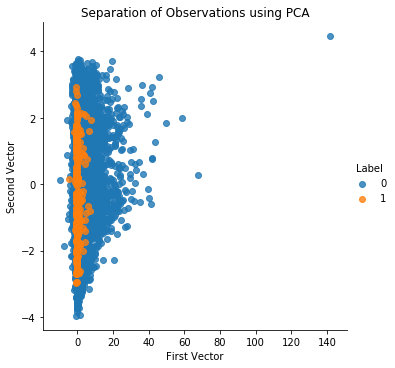

In [9]:
pca_params = {"n_components":30, "whiten":False, "random_state":2018}

pca = PCA(**pca_params)

X_train_PCA = pd.DataFrame(data=pca.fit_transform(X_train),index=X_train.index)
X_train_PCA_inverse = pd.DataFrame( data=pca.inverse_transform(X_train_PCA), index=X_train.index, \
                                  columns=X.columns)

scatterPlot( X_train_PCA, y_train, "PCA" )

Now we compute the precision-recall curve and the ROC curve:

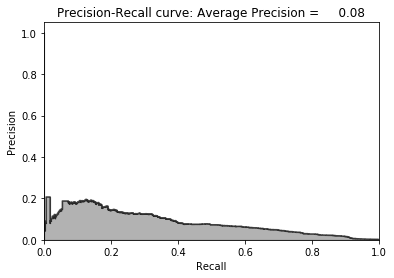

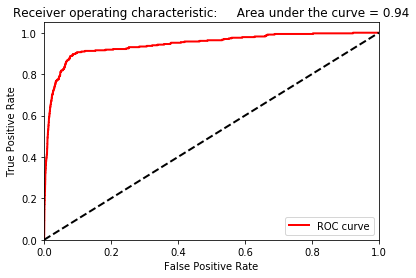

In [10]:
pca_anomaly_scores = compute_anomaly_score( X_train, X_train_PCA_inverse )
preds = plotResults( y_train, pca_anomaly_scores, True )

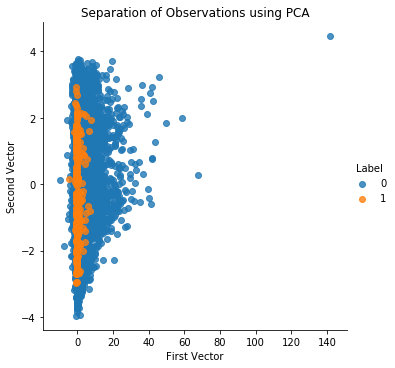

In [11]:
pca_params = {"n_components":27, "whiten":False, "random_state":2018}

pca = PCA(**pca_params)

X_train_PCA = pd.DataFrame(data=pca.fit_transform(X_train),index=X_train.index)
X_train_PCA_inverse = pd.DataFrame( data=pca.inverse_transform(X_train_PCA), index=X_train.index, \
                                  columns=X.columns)
scatterPlot( X_train_PCA, y_train, "PCA" )

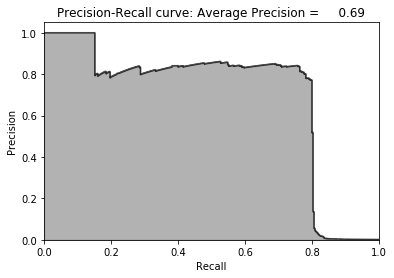

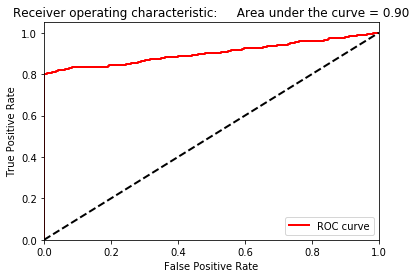

In [12]:
anomalyScoresPCA = compute_anomaly_score(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True )

Our prediction is just going to be that the 350 records with the highest anomaly score will be fraud

In [26]:
cutoff = 350
# highest anomaly scores are at top
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
# create a predictions vector 
predictions = [1] * cutoff + [0] * (preds.shape[0]-cutoff)
print(classification_report(preds.trueLabel, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190490
           1       0.75      0.80      0.78       330

    accuracy                           1.00    190820
   macro avg       0.88      0.90      0.89    190820
weighted avg       1.00      1.00      1.00    190820



The support tells you how many instances we have of each class

# Confusion Matrix Plot
***
A confusion matrix has $C_{i,j}$ has predicted to be in group j but is actually in group i. True negatives are $C_{0,0}$, True positives are $C_{1,1}$. False negatives are $C_{1,0}$

In [27]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    names = [['TN=','FP='],['FN=','TP=']]
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, names[i][j] + format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Normalized confusion matrix
[[1.00e+00 4.51e-04]
 [2.00e-01 8.00e-01]]


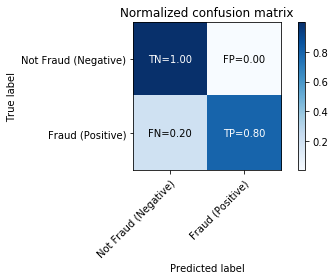

In [28]:
plot_confusion_matrix(preds.trueLabel, predictions, \
                      classes=["Not Fraud (Negative)", "Fraud (Positive)"], normalize=True,\
                      title='Normalized confusion matrix')
plt.show()

# Fraud Detection on the Test Set
***
Now we will evaluate our fraud detection system on the test set:

In [ ]:
X_test_PCA = pd.DataFrame(data=pca.transform( X_test ), index=X_test.index )
X_test_PCA_inverse = pd.DataFrame(data=pca.inverse_transform(X_test_PCA),index=X_test_PCA.index)
scatterPlot(X_test_PCA, y_test, "PCA")

In [ ]:
pca_test_anomaly_scores = compute_anomaly_score( X_test, X_test_PCA_inverse )
test_preds = plotResults( y_test, pca_test_anomaly_scores, True )

# Summary
***
We built a fraud detection system that caught over 80% of the known fraud with an 80% precision. Additional benefits to using an unsupervised system is that it does not require labels for training, it adapts well to changing fraud patterns, and it can catch fraud that had gone previously undiscovered. Given these properties, it is reasonable to believe that the unsupervised solution will generally perform better than a supervised version at catching both known and unknown, or newly emerging patterns of fraud in the future. However, using them together is most practically efficient. 